# House Prices - Adavanced Regression Techniques

### Import Necessary Libraries and Load Data
---

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import math
import optuna

# Remove future warnings (seaborn)
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [34]:
# Kaggle Paths
# train_path = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
# test_path = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'

# Local Paths
train_path = './train.csv'
test_path = './test.csv'

# Read in the data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [35]:
print(f'Train dataset shape: {train_df.shape}')
print(f'Test dataset shape: {test_df.shape}')

Train dataset shape: (1460, 81)
Test dataset shape: (1459, 80)


In [36]:
# Drop the ID column
train_df.drop('Id', axis=1, inplace=True)

# Save the test IDs for later
test_ids = test_df['Id'].copy()
test_df.drop('Id', axis=1, inplace=True)

### Exploratory Data Analysis
---

#### Data overview

In [37]:
train_df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [38]:
print(f'Categorical attributes number: {len(train_df.select_dtypes("object").columns)}')
print(f'Numerical attributes number: {len(train_df.select_dtypes(include=["int64", "float64"]).columns)}')

Categorical attributes number: 43
Numerical attributes number: 37


#### SalePrice distribution

<Axes: xlabel='SalePrice', ylabel='Count'>

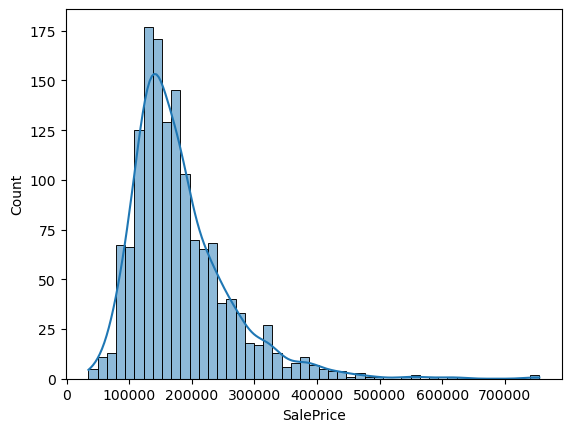

In [39]:
sns.histplot(data=train_df, x='SalePrice', kde=True)

SalePrice disribution reminds normal distribution. But it is skewed to the right. </br>
So, it's a good idea to experiment with transforming it to normal distribution (log transformation) for linear models.

#### Numerical features

In [40]:
numeric_dataset = train_df.select_dtypes(include=['int64', 'float64'])
numeric_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1452 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

A lot of numerical features have some value and there are almost no missing values. </br>

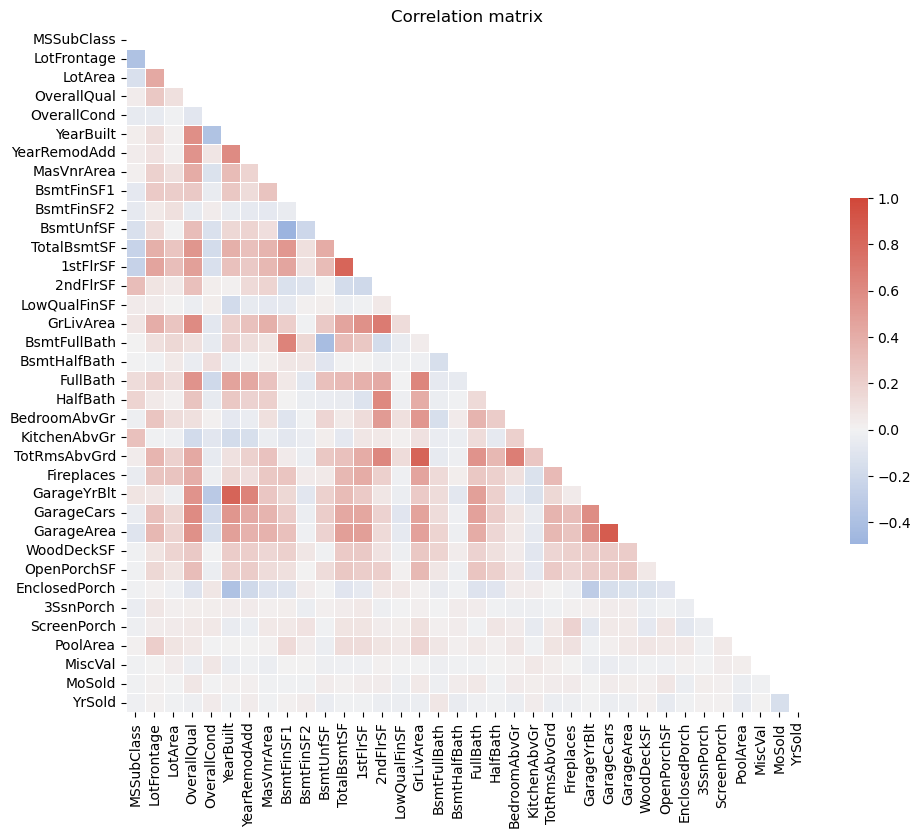

In [41]:
# Source: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

corr = train_df.select_dtypes(include=['int64', 'float64']).drop('SalePrice', axis=1, inplace=False).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
figure, axes = plt.subplots(figsize=(11, 9))
clr_map = sns.diverging_palette(255, 15, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=clr_map, vmax=1, center=0, square=True, linewidth=.5, cbar_kws={'shrink': .5})

plt.title("Correlation matrix")
plt.show()

In [42]:
corr_stack = numeric_dataset.drop('SalePrice', axis=1, inplace=False).corr().stack().reset_index()
corr_stack.rename(columns={0:'Correlation value'}, inplace=True)

# drop repeating lines and correlations between same features
corr_stack = corr_stack[corr_stack['level_0'] != corr_stack['level_1']]
corr_stack = corr_stack[corr_stack['level_0'] < corr_stack['level_1']]
corr_stack.sort_values(by='Correlation value', ascending=False, inplace=True)

print('Top 10 most correlated features:')
corr_stack.head(10)

Top 10 most correlated features:


,level_0,level_1,Correlation value
961,GarageArea,GarageCars,0.882475
869,GarageYrBlt,YearBuilt,0.825667
562,GrLivArea,TotRmsAbvGrd,0.825489
443,1stFlrSF,TotalBsmtSF,0.819530
483,2ndFlrSF,GrLivArea,0.687501
742,BedroomAbvGr,TotRmsAbvGrd,0.676620
304,BsmtFinSF1,BsmtFullBath,0.649212
870,GarageYrBlt,YearRemodAdd,0.642277
663,FullBath,GrLivArea,0.630012
490,2ndFlrSF,TotRmsAbvGrd,0.616423


It can be seen that some features are correlated. </br>
For example, GarageCars and GarageArea are very much related (obviously, the more cars you can park, the more area you need). So, later we can drop one of these features (GarageCars). </br>
Also, GarageYrBuilt and YearBuilt are very much related. It's not surprising, because most of the garages were built with the houses. I will keep only YearBuilt feature. </br>
TotalBsmtSF and 1stFlrSF are also correlated. First floor is near to the basement area, so it's not surpising, that these features are related. </br>
GrLivArea and TotRmsAbvGrd are also correlated. The more rooms you have, the more area you need. I will keep only GrLivArea.</br>

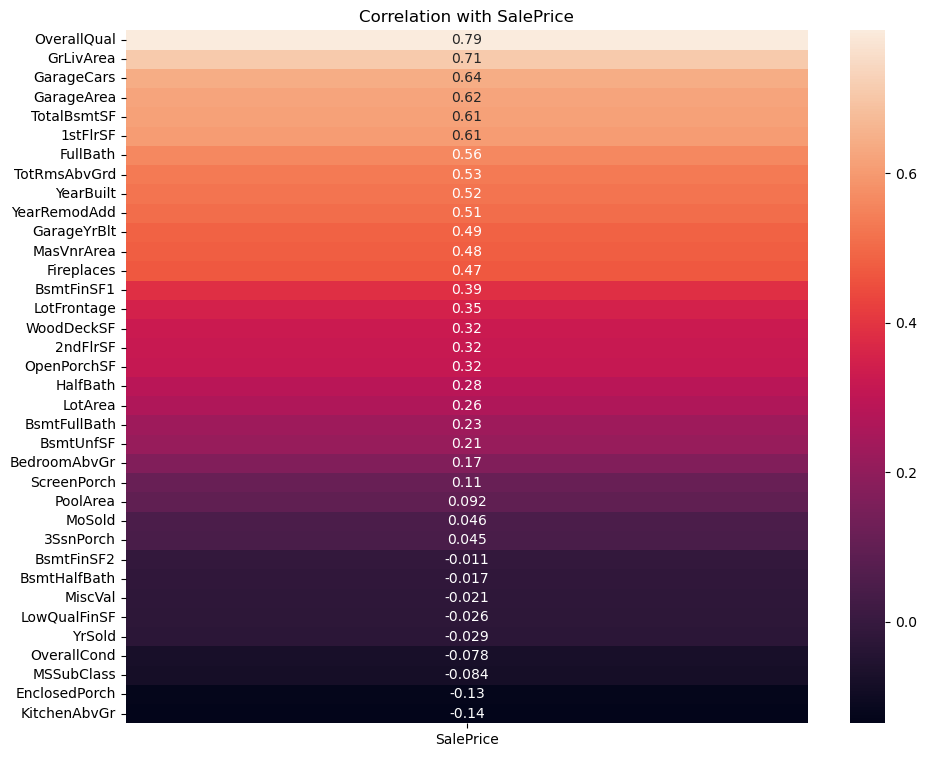

In [43]:
figure, axes = plt.subplots(figsize=(11, 9))
corr = numeric_dataset.corr()[['SalePrice']]
corr.drop(['SalePrice'], axis=0, inplace=True)
corr.sort_values(by='SalePrice', ascending=False, inplace=True)

sns.heatmap(corr, ax=axes, annot=True)
plt.title('Correlation with SalePrice')
plt.show()

In [44]:
numeric_dataset.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### Categorical features

In [45]:
categorical_dataset = train_df.select_dtypes(include=['object'])
categorical_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   Alley          91 non-null     object
 3   LotShape       1460 non-null   object
 4   LandContour    1460 non-null   object
 5   Utilities      1460 non-null   object
 6   LotConfig      1460 non-null   object
 7   LandSlope      1460 non-null   object
 8   Neighborhood   1460 non-null   object
 9   Condition1     1460 non-null   object
 10  Condition2     1460 non-null   object
 11  BldgType       1460 non-null   object
 12  HouseStyle     1460 non-null   object
 13  RoofStyle      1460 non-null   object
 14  RoofMatl       1460 non-null   object
 15  Exterior1st    1460 non-null   object
 16  Exterior2nd    1460 non-null   object
 17  MasVnrType     588 non-null    object
 18  ExterQual      1460 non-null

It can be seen that some categorical features (**PoolQC**, **MiscFeature**, **Alley**) have a lot of missing values. So we can drop them.

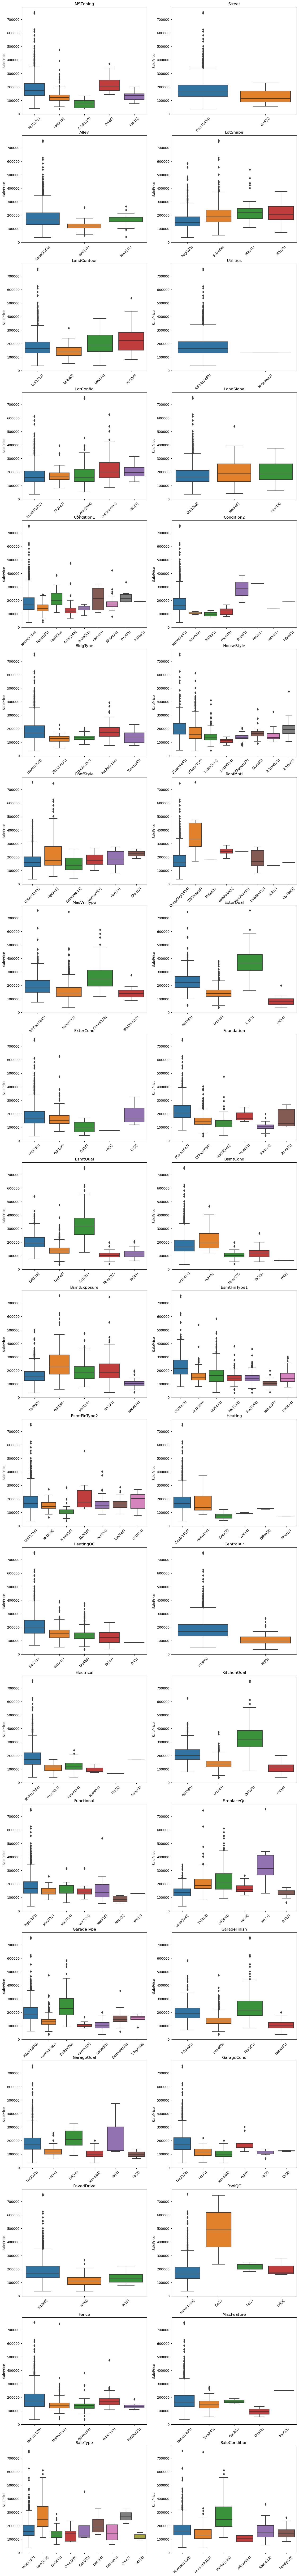

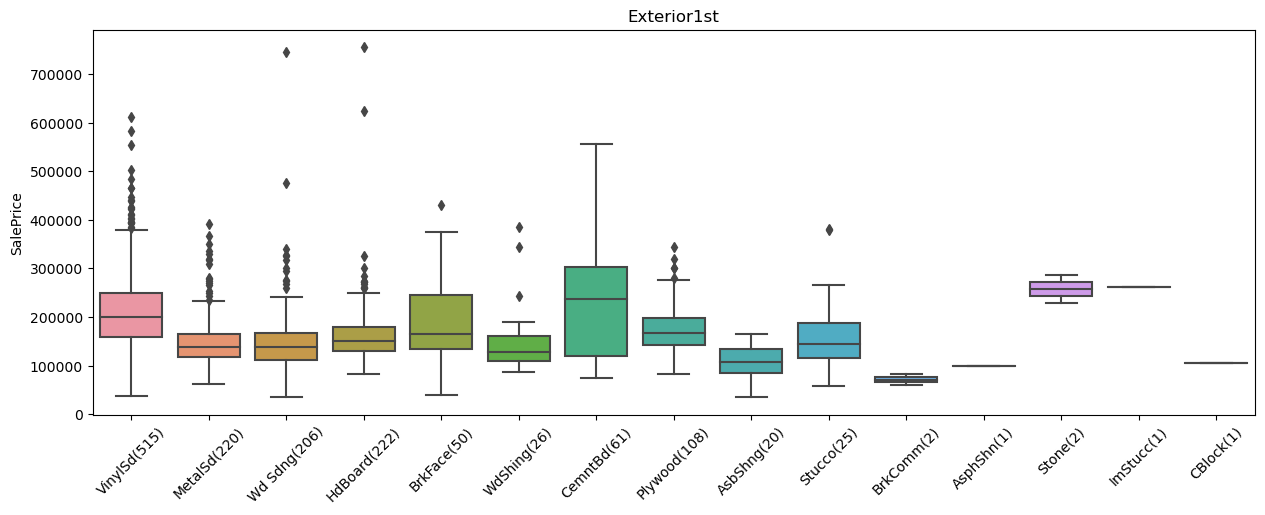

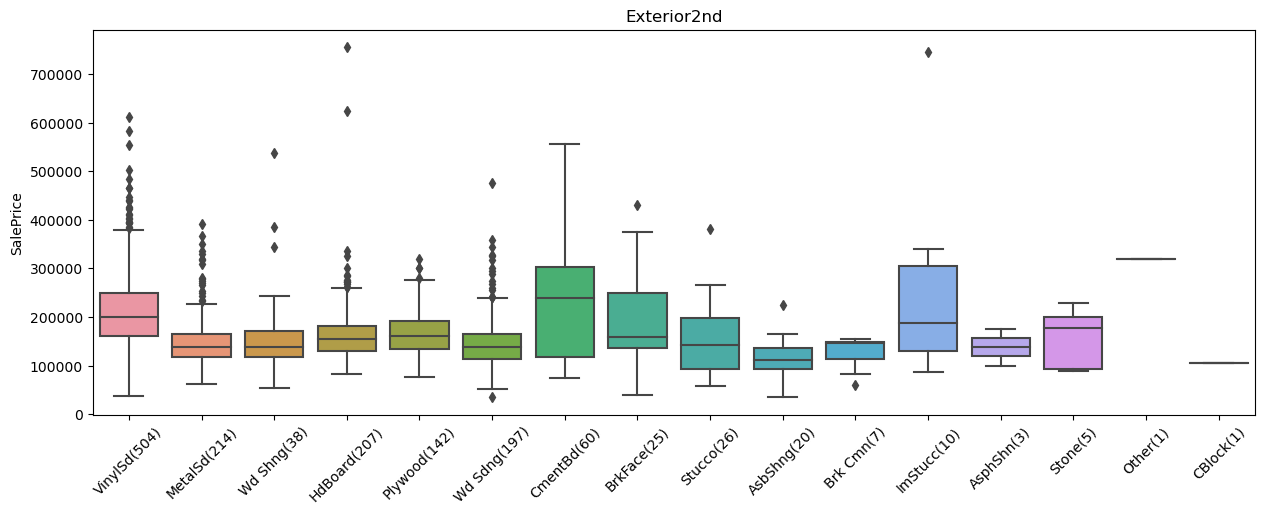

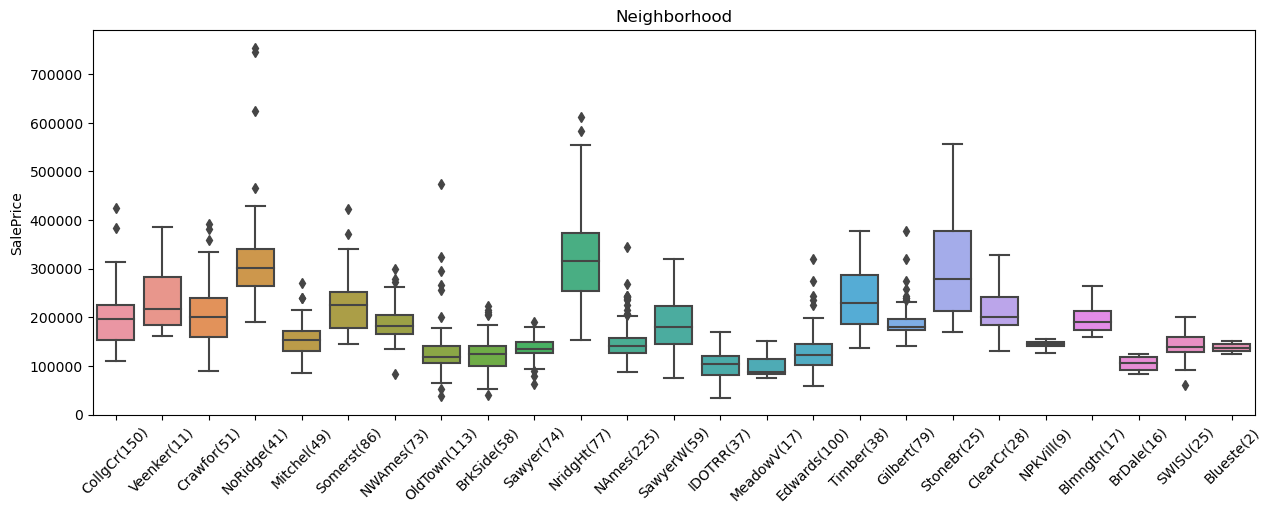

In [46]:
categorical_features = categorical_dataset.columns

categorical_copy = categorical_dataset.copy()
for feature in categorical_features:
    if categorical_copy[feature].isnull().any():
        categorical_copy[feature] = categorical_copy[feature].fillna('None')

variative_features = ['Exterior1st', 'Exterior2nd', 'Neighborhood']
col_num = 2
row_num = math.ceil((len(categorical_features) - 3) / 2)
features_for_plot = categorical_features.drop(variative_features)

def boxplot(x, y, axes, data):
    plot = sns.boxplot(data=data, x=x, y=y, ax=axes)
    plot.set_title(x)
    plot.set(xlabel=None)
    xticks = [f"{label}({data[feature].to_list().count(label)})" for label in data[feature].unique()]
    plot.set_xticklabels(xticks, rotation=45)

figure, axes = plt.subplots(row_num, col_num, figsize=(15, row_num * 7))
for i, feature in enumerate(features_for_plot):
    boxplot(feature, train_df['SalePrice'], axes[i // col_num, i % col_num], categorical_copy)

for feature in variative_features:
    figure, axes = plt.subplots(figsize=(15, 5))
    boxplot(feature, train_df['SalePrice'], axes, categorical_copy)


### Data preprocessing
---

In [47]:
dataframes = [train_df, test_df]

Drop numerical features: **GarageCars**, **GarageYrBlt**, **1stFlrSF**, **TotRmsAbvGrd** </br>

In [48]:
for df in dataframes:   
    df.drop(['GarageCars', 'GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd'], axis=1, inplace=True)

Drop categorical features: **PoolQC**, **Fence** </br>

In [49]:
for df in dataframes:
    df.drop(['PoolQC', 'Fence'], axis=1, inplace=True)

In [50]:
# Missing values
for df, df_name in zip(dataframes, ['Train', 'Test']):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    missing_values.sort_values(inplace=True, ascending=False)
    print(f'{df_name} dataset missing values:')
    print(missing_values)

Train dataset missing values:
MiscFeature     1406
Alley           1369
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64
Test dataset missing values:
MiscFeature     1408
Alley           1352
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageFinish      78
GarageCond        78
GarageQual        78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
GarageArea         1
BsmtFinSF2         1
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
Sale

**FireplaceQu**: NA means "no fireplace", so we can replace NA with "None" as new category. </br>

In [51]:
for df in dataframes:
    df['FireplaceQu'].fillna('None', inplace=True)

**Alley**, **MiscFeature**:

It can be seen, that houses that don't have this features are more expensive. So, we can replace both of them with one binary feature. (1 if house has Alley or MiscFeature, 0 otherwise) </br>

In [52]:
for df in dataframes:
    df['AlleyMisc'] = (df['Alley'].notna() | df['MiscFeature'].notna()).astype(int)
    df.drop(['Alley', 'MiscFeature'], axis=1, inplace=True)

**LotFrontage** </br>

<Axes: xlabel='LotFrontage', ylabel='Count'>

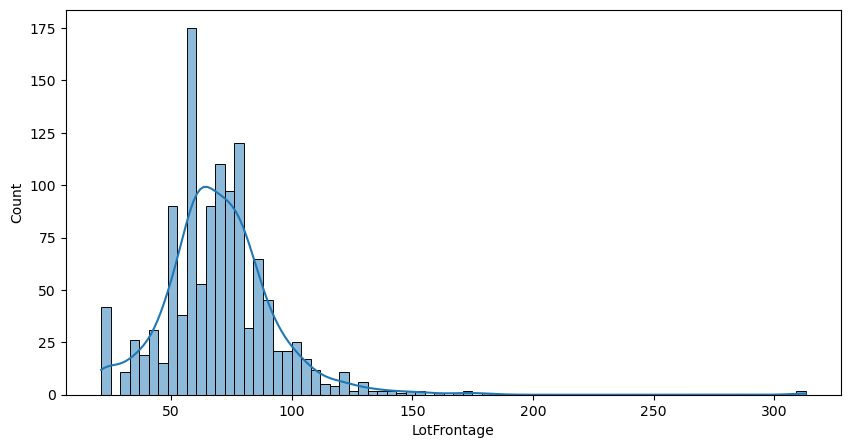

In [53]:
# histogram
figure, axes = plt.subplots(figsize=(10, 5))
sns.histplot(data=train_df, x='LotFrontage', kde=True, ax=axes)

<Axes: xlabel='LotFrontage', ylabel='SalePrice'>

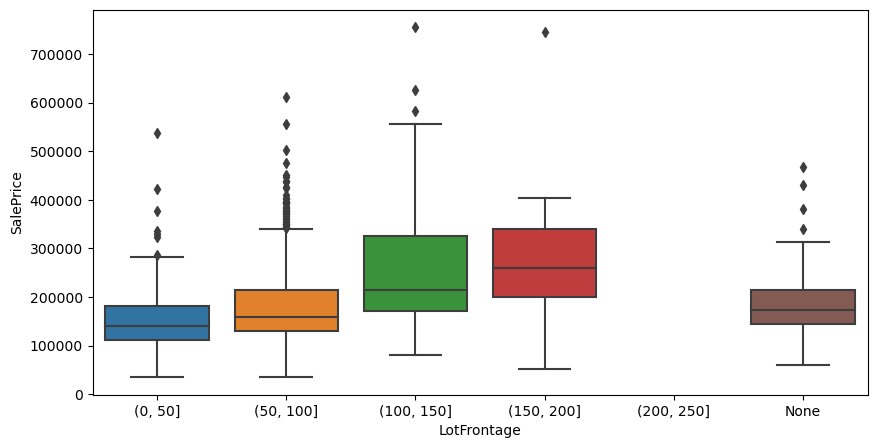

In [54]:
# boxplot
figure, axes = plt.subplots(figsize=(10, 5))
copy = train_df.copy()

copy['LotFrontage'] = pd.cut(copy['LotFrontage'], bins=[i for i in range(0, 251, 50)]).values.add_categories('None')
copy['LotFrontage'].fillna('None', inplace=True)
sns.boxplot(data=copy, x='LotFrontage', y='SalePrice', ax=axes)

As it can be seen, NA values in LotFrontage has the same SalePrice as values in range (50 - 100]. Also this range has the most of values. So, we can replace NA with median value. </br>

In [55]:
for df in dataframes:
    df['LotFrontage'].fillna(df['LotFrontage'].median(), inplace=True)

**Garage**, **Basement**: NA means "no garage"/"no basement", so we can replace NA with "None" as new category. </br>

In [56]:
cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
        'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath']
for df in dataframes:
        df[cols] = df[cols].fillna('None')

**MasVnrType**, **MasVnrArea**: NA means "no masonry veneer", so we can replace NA with "None" as new category. </br>

In [57]:
for df in dataframes:
    df['MasVnrType'].fillna('None', inplace=True)
    df['MasVnrArea'].fillna(0, inplace=True)

In [58]:
for df, df_name in zip(dataframes, ['Train', 'Test']):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    missing_values.sort_values(inplace=True, ascending=False)
    print(f'{df_name} dataset missing values:')
    print(missing_values)

Train dataset missing values:
Electrical    1
dtype: int64
Test dataset missing values:
MSZoning       4
Utilities      2
Functional     2
Exterior1st    1
Exterior2nd    1
TotalBsmtSF    1
KitchenQual    1
GarageArea     1
SaleType       1
dtype: int64


In [59]:
# Fill the rest of the missing values with the most frequent value among houses with same OverallQual

for df in dataframes:
    columns_with_empty_values = df.columns[df.isnull().any()]
    for column in columns_with_empty_values:
        default_value = 0 if df[column].dtype in ('int64', 'float64') else 'None'
        df[column].fillna(df.groupby('OverallQual')[column].transform(lambda x: x.mode()[0] if not x.mode().empty else default_value), inplace=True)

### CatBoost
---

#### Hyperparameters tuning

In [60]:
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

#### Model training

In [61]:
# def objective(trial):
#     params = {
#         "iterations": trial.suggest_int("iterations", 500, 1000),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
#         "depth": trial.suggest_int("depth", 1, 10),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
#     }

#     model = CatBoostRegressor(**params, silent=True, cat_features=list(train_df.select_dtypes(include=['object']).columns))
#     model.fit(X_train, y_train)
#     predictions = model.predict(X_test)
#     rmse = mean_squared_error(y_test, predictions, squared=False)
#     return rmse


# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=20)

In [62]:
cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.0446, depth=4, subsample=0.7943, colsample_bylevel=0.99015, min_data_in_leaf=56, loss_function='RMSE', random_seed=42, cat_features=list(train_df.select_dtypes(include=['object']).columns), verbose=0)
cat_model.fit(X_train, y_train, verbose=False)

scores = cross_val_score(cat_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', verbose=False)
print(f'Cross validation scores: {-scores.mean()}')

Cross validation scores: 26691.979449362563


#### Top Features

<Axes: xlabel='importance', ylabel='feature'>

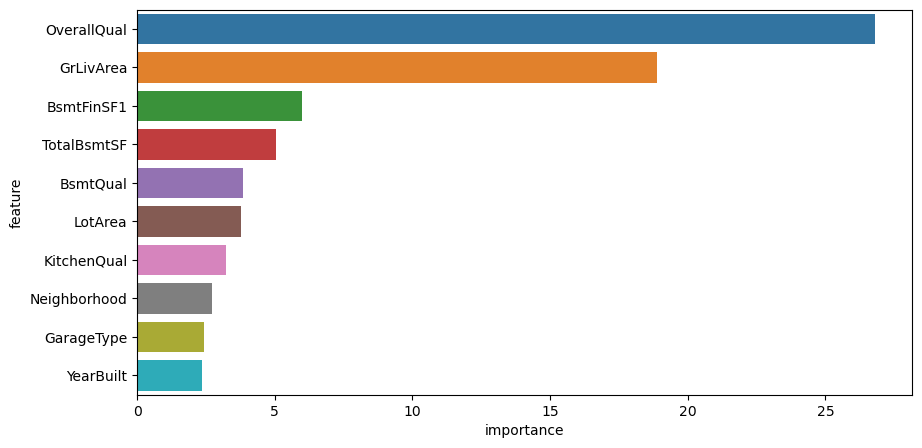

In [63]:
feature_importances = cat_model.get_feature_importance()

feature_importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})
feature_importances_df.sort_values(by='importance', ascending=False, inplace=True)

top = feature_importances_df.head(10)

figure, axes = plt.subplots(figsize=(10, 5))
sns.barplot(data=top, x='importance', y='feature', ax=axes)

#### Prediction

In [64]:
predictions = cat_model.predict(test_df)
predictions = pd.Series(predictions)

submission = pd.read_csv('./sample_submission.csv')
submission['SalePrice'] = predictions
submission.to_csv('submission.csv', index=False)